<a href="https://colab.research.google.com/github/AhmadSaleh22/BrainTumor/blob/master/ahmad_xcep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import zipfile
import shutil, os

fantasy_zip = zipfile.ZipFile('/content/gdrive/My Drive/brain-umer-4-classes.zip')
fantasy_zip.extractall('/content/gdrive/My Drive/ahmad-saleh')
fantasy_zip.close()

In [ ]:
%tensorflow_version 1.x

In [ ]:
base_dir="/content/gdrive/My Drive/ahmad-saleh"

In [ ]:
#number of files in each class

import fnmatch
import os

  
for i in os.listdir(base_dir+"/Training"):
    dir_name=base_dir+"/Training/"+i 
    numfiles = len([f for f in os.listdir(dir_name) if os.path.isfile(os.path.join(dir_name, f)) and f[0] != '.'])
    print(numfiles,i)

826 glioma_tumor
822 meningioma_tumor
395 no_tumor
827 pituitary_tumor


In [ ]:
#number of files in each class

import fnmatch
import os


for i in os.listdir(base_dir+"/Testing"):
    dir_name=base_dir+"/Testing/"+i 
    numfiles = len([f for f in os.listdir(dir_name) if os.path.isfile(os.path.join(dir_name, f)) and f[0] != '.'])
    print(numfiles,i)

100 glioma_tumor
115 meningioma_tumor
105 no_tumor
74 pituitary_tumor


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

In [ ]:
img_width, img_height = 256, 256
nb_train_samples = 2870
nb_validation_samples = 2870
epochs = 20
batch_size = 128
n_classes = 4

In [ ]:
import fnmatch
import os
import numpy as np
import pandas as pd
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

np.random.seed(41)

path = base_dir+"/Training/"
train_label = []
train_img = []
label2num = {'glioma_tumor':0,'meningioma_tumor':1,'no_tumor':2, 'pituitary_tumor':3}

num_classes = 4

for i in os.listdir(path):
    print(i)
    label_number = label2num[i]
    new_path = path+i+'/'  
    for j in fnmatch.filter(os.listdir(new_path), '*.jpg'): 
        temp_img = image.load_img(new_path+j, target_size=(256,256))
        train_label.append(label_number)
        temp_img = image.img_to_array(temp_img)
        train_img.append(temp_img)
        
train_img = np.array(train_img)
train_y=pd.get_dummies(train_label)
train_y = np.array(train_y)
train_img=preprocess_input(train_img)



print('Training data shape: ', train_img.shape)
print('Training labels shape: ', train_y.shape)



glioma_tumor
meningioma_tumor
no_tumor
pituitary_tumor
Training data shape:  (2870, 256, 256, 3)
Training labels shape:  (2870, 4)


In [ ]:
import keras
from keras import models, layers
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import GlobalMaxPooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

def new_model1(num_classes=None):

    base_model = applications.Xception(weights= 'imagenet', include_top=False, input_shape= (256,256,3))

    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    predictions = Dense(num_classes, activation= 'softmax')(x)
    model = Model(inputs = base_model.input, outputs = predictions)
 

    return model

In [ ]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

In [ ]:
import keras
from keras import backend as K
num_classes=4
model = new_model1(num_classes)

model.compile(keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',fscore])
model.summary()

83689472/83683744 [==============================] - 2s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________

In [ ]:
#Split training data into rain set and validation set
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(train_img,train_y,test_size=0.30, random_state=121)

In [ ]:

#Data augmentation
from keras.preprocessing.image import ImageDataGenerator
gen_train = ImageDataGenerator( 
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True

)
gen_train.fit(X_train)



In [ ]:
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('/content/gdrive/My Drive/my_checkpoint/ahmad-xcep.h5', monitor='val_loss', save_best_only=True)

history = model.fit_generator(gen_train.flow(X_train, Y_train, batch_size=32, shuffle=True), 
                    steps_per_epoch=(X_train.shape[0]//(4*batch_size)), 
                    epochs=epochs, 
                    validation_data=(X_valid,Y_valid),
                    callbacks=[model_checkpoint],
                    verbose=1)

Epoch 1/20
3/3 [==============================] - 14s 5s/step - loss: 2.0344 - accuracy: 0.2917 - fscore: 0.2646 - val_loss: 3.9030 - val_accuracy: 0.1336 - val_fscore: 0.1328
Epoch 2/20
3/3 [==============================] - 5s 2s/step - loss: 1.1685 - accuracy: 0.5417 - fscore: 0.3893 - val_loss: 2.9480 - val_accuracy: 0.1336 - val_fscore: 0.1328
Epoch 3/20
3/3 [==============================] - 5s 2s/step - loss: 1.0351 - accuracy: 0.5521 - fscore: 0.4259 - val_loss: 2.3023 - val_accuracy: 0.1301 - val_fscore: 0.1269
Epoch 4/20
3/3 [==============================] - 5s 2s/step - loss: 1.0602 - accuracy: 0.5521 - fscore: 0.3473 - val_loss: 2.0656 - val_accuracy: 0.1347 - val_fscore: 0.1153
Epoch 5/20
3/3 [==============================] - 5s 2s/step - loss: 1.0751 - accuracy: 0.5000 - fscore: 0.4682 - val_loss: 1.9180 - val_accuracy: 0.1521 - val_fscore: 0.1067
Epoch 6/20
3/3 [==============================] - 5s 2s/step - loss: 0.7360 - accuracy: 0.7292 - fscore: 0.6280 - val_loss: 

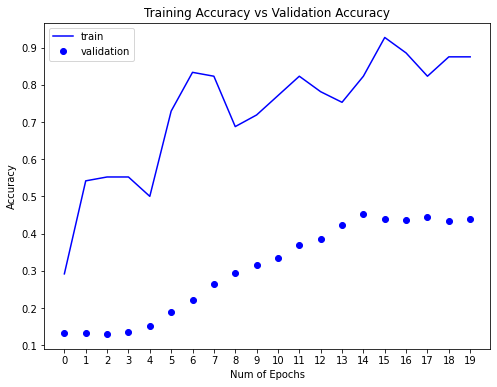

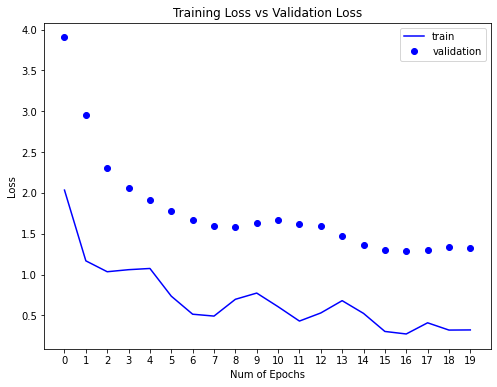

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(0)
plt.plot(history.history['accuracy'],'b')
plt.plot(history.history['val_accuracy'],'bo')
plt.xticks(np.arange(0, 20, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'bo')
plt.xticks(np.arange(0, 20, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])


In [ ]:
model.save_weights("/content/gdrive/My Drive/my_checkpoint/ahmad-xcep.h5")
 

In [ ]:
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('/content/gdrive/My Drive/my_checkpoint/ahmad-xcep.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, Y_train,
                    batch_size=32, 
                    epochs=epochs, 
                    validation_data=(X_valid,Y_valid),
                    shuffle=True, 
                    callbacks=[model_checkpoint],
                    verbose=1)
 

Train on 2009 samples, validate on 861 samples
Epoch 1/20
2009/2009 [==============================] - 37s 18ms/step - loss: 0.2732 - accuracy: 0.9000 - fscore: 0.9014 - val_loss: 0.7623 - val_accuracy: 0.6527 - val_fscore: 0.6478
Epoch 2/20
2009/2009 [==============================] - 37s 18ms/step - loss: 0.0262 - accuracy: 0.9935 - fscore: 0.9933 - val_loss: 0.2733 - val_accuracy: 0.8873 - val_fscore: 0.8935
Epoch 3/20
2009/2009 [==============================] - 37s 18ms/step - loss: 0.0131 - accuracy: 0.9965 - fscore: 0.9965 - val_loss: 0.1713 - val_accuracy: 0.9408 - val_fscore: 0.9403
Epoch 4/20
2009/2009 [==============================] - 37s 18ms/step - loss: 0.0112 - accuracy: 0.9955 - fscore: 0.9955 - val_loss: 0.1804 - val_accuracy: 0.9466 - val_fscore: 0.9459
Epoch 5/20
2009/2009 [==============================] - 37s 18ms/step - loss: 0.0089 - accuracy: 0.9985 - fscore: 0.9985 - val_loss: 0.1760 - val_accuracy: 0.9524 - val_fscore: 0.9522
Epoch 6/20
2009/2009 [===========

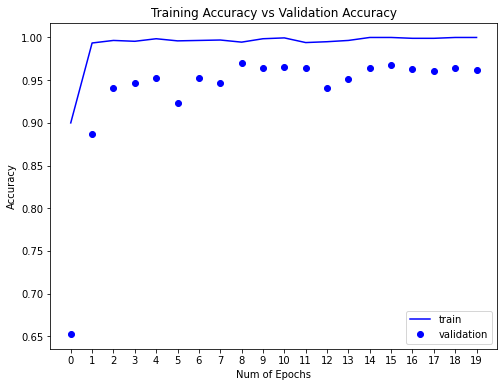

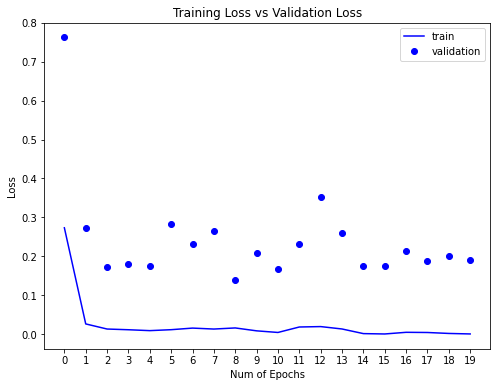

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(0)
plt.plot(history.history['accuracy'],'b')
plt.plot(history.history['val_accuracy'],'bo')
plt.xticks(np.arange(0, 20, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'bo')
plt.xticks(np.arange(0, 20, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])



In [ ]:
model.load_weights("/content/gdrive/My Drive/my_checkpoint/ahmad-xcep.h5")
 

In [ ]:
import fnmatch
import os
import numpy as np
import pandas as pd
# pre-trained model 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

np.random.seed(21)
totalAll=0
countAll =0

path = "/content/gdrive/My Drive/ahmad-saleh/Test1/"
num2label = {0:'glioma_tumor',1:'meningioma_tumor',2:'no_tumor', 3:'pituitary_tumor'}
label2num = {'glioma_tumor':0,'meningioma_tumor':1,'no_tumor':2, 'pituitary_tumor':3}
for i in os.listdir(path):
    
    label_number = label2num[i]
    new_path = path+i+'/'  
    count=0
    total=0
    for j in fnmatch.filter(os.listdir(new_path), '*.jpg')[0:100]: 
        img = image.load_img(new_path+j, target_size=(256, 256) )
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        pred=model.predict(x)
        max_score =0.0
        lab=-1
        pred = pred[0]
        for k in range(4):
            if (pred[k]>max_score):
                max_score=pred[k]
                lab=k
       
        file = num2label[lab]
        total=total+1
        if file == i:
             count=count+1
    countAll=countAll + count
    totalAll = totalAll + total
    print('count total : ', i, count, total)
print('acc= : ', countAll, totalAll, countAll/totalAll*100)



count total :  glioma_tumor 99 100
count total :  meningioma_tumor 99 100
count total :  no_tumor 97 100
count total :  pituitary_tumor 100 100
acc= :  395 400 98.75
